In [16]:
import time
import random
from typing import List, Callable
from dataclasses import dataclass

import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from src.genetic import fitness
from src.simulation import Simulation
from src.pid import PIDController
from src.visualization import VisualizationFactory, VisualizationType

In [17]:
def get_id_generator():
    num = 1
    while True:
        yield num
        num += 1

id_generator = get_id_generator()

In [18]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [19]:
@dataclass
class Genome:
    id: int
    p: float
    i: float
    d: float
    generation: int
    fitness: float = 0.0
    is_mutated: bool = False
    got_killed: bool = True

In [20]:
def generate_population(population_size: int, p_min: float, p_max: float, i_min: float, i_max: float, d_min: float, d_max: float) -> List[Genome]:
    p = np.random.uniform(p_min, p_max, population_size)
    i = np.random.uniform(i_min, i_max, population_size)
    d = np.random.uniform(d_min, d_max, population_size)
    population = np.array([p, i, d]).transpose()
    
    genomes = []
    for genome in population:
        genomes.append(Genome(id=next(id_generator), p=genome[0], i=genome[1], d=genome[2], generation=1))
        
    return genomes

In [21]:
def select_genomes(selection_size: int, genomes: List[Genome], errors: List[float]) -> List[Genome]:
    assert selection_size % 2 == 0
    indices_of_smallest_error = sorted(range(len(errors)), key=lambda i: errors[i])[:selection_size]
    best_genomes = [genomes[i] for i in indices_of_smallest_error]

    for genome in best_genomes:
        genome.got_killed = False
    
    return best_genomes

In [22]:
def calculate_fitness(genome: Genome, simulation: Simulation, setpoints: List[float], external_force: List[float], fitness_func: Callable) -> float:
    pid_controller = PIDController(genome.p, genome.i, genome.d, setpoint=setpoints[0])
    
    positions = []
    position = 0
    for idx, setpoint in enumerate(setpoints):
        pid_controller.setpoint = setpoint
        new_angle = pid_controller.next(position)
        _, _, position = simulation.next(new_angle, external_force[idx])
        positions.append(position)
        
    error = fitness_func(positions, setpoints, weight_factor)
    return error, positions

In [23]:
def crossover(parents: List[Genome], crossover_rate: int) -> List[Genome]:
    children = []
    for mother, father in batch(parents, n=2):
        p_mean, i_mean, d_mean = (mother.p + father.p) / 2, (mother.i + father.i) / 2, (mother.d + father.d) / 2
        p_std_dev, i_std_dev, d_std_dev = abs(mother.p - p_mean), abs(mother.i - i_mean), abs(mother.d - d_mean)
        
        p_children = np.random.normal(p_mean, p_std_dev, crossover_rate)
        i_children = np.random.normal(i_mean, i_std_dev, crossover_rate)
        d_children = np.random.normal(d_mean, d_std_dev, crossover_rate)
        
        for p, i, d in zip(p_children, i_children, d_children):
            children.append(Genome(id=next(id_generator), p=p, i=i, d=d, generation=mother.generation + 1))
            
    return children

In [24]:
def mutate(children: List[Genome], mutation_probability: float, mutation_impact: float) -> List[Genome]:
    p_vals = [genome.p for genome in children]
    i_vals = [genome.i for genome in children]
    d_vals = [genome.d for genome in children]

    p_mean = np.mean(p_vals)
    p_std_dev = np.std(p_vals)
    i_mean = np.mean(i_vals)
    i_std_dev = np.std(i_vals)
    d_mean = np.mean(d_vals)
    d_std_dev = np.std(d_vals)

    num_mutations = 0
    mutated_genomes = []
    for genome in children:
        if random.uniform(0, 1) < mutation_probability:
            num_mutations += 1
            mutated_p = np.random.normal(p_mean, p_std_dev * mutation_impact)
            mutated_i = np.random.normal(i_mean, i_std_dev * mutation_impact)
            mutated_d = np.random.normal(d_mean, d_std_dev * mutation_impact)
            mutated_genomes.append(Genome(id=genome.id, p=mutated_p, i=mutated_i, d=mutated_d, generation=genome.generation, is_mutated=True))
        else:
            mutated_genomes.append(genome)

    return mutated_genomes

In [25]:
population_size = 120
selection_size = 30
crossover_rate = 8
mutation_probability = 0.2
mutation_impact = 5
num_generations = 20
p_min, p_max = -30, 30
i_min, i_max = -1, 1
d_min, d_max = -300, 300

In [26]:
fps = 30
setpoints = [-10] * fps * 10 + [5] * fps * 10 + [0] * fps * 40 + [8] * fps * 10 + [0] * fps * 10
external_force = [0] * fps * 30 + [1] * fps * 50
mass = 0.2
delta_t = 1 / fps
weight_factor = 0.4

In [27]:
start = time.time()
population = generate_population(population_size, p_min, p_max, i_min, i_max, d_min, d_max)
all_genomes = population.copy()
smallest_error = None
best_genome = None
best_genome_positions = None
for generation in range(num_generations):
    errors = []
    for genome in population:
        error, positions = calculate_fitness(genome, Simulation(mass=mass, delta_t=delta_t), setpoints, external_force, fitness)
        genome.fitness = error
        if smallest_error is None or genome.fitness < smallest_error:
            smallest_error = genome.fitness
            best_genome = genome
            best_genome_positions = positions
        errors.append(error)

    print(f'Min. Error: {np.min(errors)}')

    parents = select_genomes(selection_size, population, errors)
    children = crossover(parents, crossover_rate)
    population = mutate(children, mutation_probability, mutation_impact)
    all_genomes += population

print(f'Simulated {round(population_size * num_generations * len(setpoints) * delta_t / (60 * 60 * 24), 2)} days in {round(time.time() - start, 2)} seconds')
print(best_genome)

Min. Error: 1881.8081587994382
Min. Error: 1185.9932537599493
Min. Error: 1074.0474490712481
Min. Error: 778.4334184553475
Min. Error: 772.7992462867127
Min. Error: 727.315456964038
Min. Error: 702.1973077537066
Min. Error: 693.8302752007035
Min. Error: 688.705196562408
Min. Error: 694.9217852690249
Min. Error: 685.7317024151915
Min. Error: 688.8336513823344
Min. Error: 686.8720584106252
Min. Error: 688.0890472806426
Min. Error: 681.7256587892914
Min. Error: 679.8024795331759
Min. Error: 681.0462491840774
Min. Error: 681.8279473943879
Min. Error: 674.6857870767061
Min. Error: 681.4049452694703
Simulated 2.22 days in 12.02 seconds
Genome(id=2161, p=-9.676421758177103, i=-0.015657198614502123, d=-224.21293706289572, generation=19, fitness=674.6857870767061, is_mutated=True, got_killed=False)


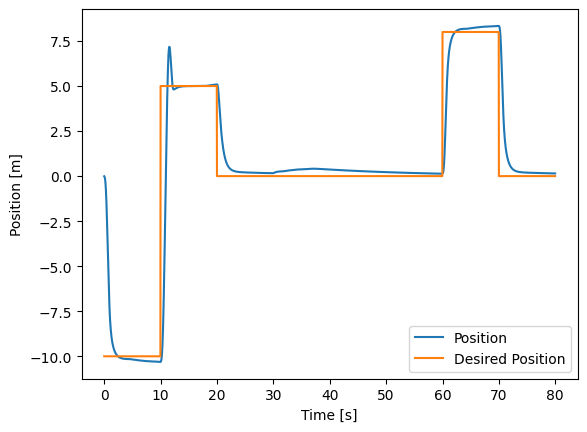

In [28]:
plt.plot(np.arange(len(setpoints)) / fps, best_genome_positions)
plt.plot(np.arange(len(setpoints)) / fps, setpoints)

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Position', 'Desired Position'])

plt.show()

In [29]:
def update_plot(generation, show_selection):
    generation_genomes = [genome for genome in all_genomes if genome.generation == generation]
    p = [genome.p for genome in generation_genomes]
    i = [genome.i for genome in generation_genomes]
    d = [genome.d for genome in generation_genomes]
    
    plot_data = {
        'id': [genome.id for genome in generation_genomes],
        'P': p,
        'I': i,
        'D': d,
        'fitness': [genome.fitness for genome in generation_genomes],
        'got_killed': [genome.got_killed for genome in generation_genomes],
        'mutated': [genome.is_mutated for genome in generation_genomes]
    }

    color_map = {True: 'red', False: 'green'}
    symbol_map = {True: 'diamond-open', False: 'circle'}
    fig = px.scatter_3d(
        plot_data, 
        x='P', y='I', z='D', 
        color='got_killed' if show_selection else 'fitness', color_discrete_map=color_map, 
        symbol='mutated', symbol_sequence=[symbol_map[mutated] for mutated in plot_data['mutated']],
        hover_data={'id': True, 'P': True, 'I': True, 'D': True, 'got_killed': True, 'mutated': True}
    )
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=[min(np.min(p), p_min), max(np.max(p), p_max)]),
            yaxis=dict(range=[min(np.min(i), i_min), max(np.max(i), i_max)]),
            zaxis=dict(range=[min(np.min(d), d_min), max(np.max(d), d_max)])
        ),
        width=800,
        height=800
    )
    fig.show()

generation_slider = widgets.IntSlider(value=1, min=1, max=num_generations, description='Generation')
show_selection_checkbox = widgets.Checkbox(value=False, description='Show Selection')

interactive_plot = widgets.interactive(update_plot, generation=generation_slider, show_selection=show_selection_checkbox)
display(interactive_plot)

interactive(children=(IntSlider(value=1, description='Generation', max=20, min=1), Checkbox(value=False, descr…

In [30]:
search_id = 2161
genome = next(filter(lambda genome: genome.id == search_id, all_genomes))
visualization = VisualizationFactory.create_visualization(VisualizationType.PID, kp=genome.p, ki=genome.i, kd=genome.d)
visualization.run()